# Model Training

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timm
from sklearn.metrics import classification_report
import requests
import zipfile
from PIL import Image
from tqdm import tqdm
import time

In [ ]:
# Download the dataset
def download_dataset():
    url = "http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip"
    if not os.path.exists("UCMerced_LandUse.zip"):
        print("Downloading UC Merced Land Use dataset...")
        r = requests.get(url, stream=True)
        with open("UCMerced_LandUse.zip", "wb") as f:
            total_length = int(r.headers.get('content-length'))
            for chunk in tqdm(r.iter_content(chunk_size=1024), total=(total_length//1024)+1):
                if chunk:
                    f.write(chunk)

    # Extract if the folder doesn't exist
    if not os.path.exists("UCMerced_LandUse"):
        print("Extracting dataset...")
        with zipfile.ZipFile("UCMerced_LandUse.zip", 'r') as zip_ref:
            zip_ref.extractall(".")

# Dataset class
class UCMercedDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train', train_ratio=0.8):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Get all image paths and labels
        self.images = []
        self.labels = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(class_idx)

        # Split into train and test sets
        indices = np.arange(len(self.images))
        np.random.seed(42)
        np.random.shuffle(indices)
        split_idx = int(len(indices) * train_ratio)

        if split == 'train':
            self.indices = indices[:split_idx]
        else:  # test
            self.indices = indices[split_idx:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path = self.images[self.indices[idx]]
        label = self.labels[self.indices[idx]]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    best_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} - {phase}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # Save the best model
                torch.save(best_model_wts, 'best_ucmerced_model.pth')
                print(f"Saved new best model with accuracy: {best_acc:.4f}")

        # Update learning rate
        if scheduler:
            scheduler.step()

        time_elapsed = time.time() - start_time
        print(f'Epoch complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print()

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def main():

    download_dataset()

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Transformations for training and testing
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create datasets
    train_dataset = UCMercedDataset(root_dir="UCMerced_LandUse/Images", transform=train_transform, split='train')
    test_dataset = UCMercedDataset(root_dir="UCMerced_LandUse/Images", transform=test_transform, split='test')

    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Class names: {train_dataset.classes}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    dataloaders = {'train': train_loader, 'val': test_loader}

    # Create model - use ResNet50 from TIMM
    print("Creating model...")
    model = timm.create_model('resnet50', pretrained=True)

    # Modify the final layer to match our number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    # Train the model
    print("Training model...")
    model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=5, device=device)

    # Evaluate the model
    print("Evaluating model...")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    # Save model
    torch.save(model.state_dict(), 'ucmerced_resnet50.pth')
    print("Model saved as 'ucmerced_resnet50.pth'")

    # Load the trained model for inference
    def load_model_for_inference(model_path, num_classes):
        model = timm.create_model('resnet50', pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        return model

    # Example of loading the trained model
    print("\nLoading trained model for inference...")
    inference_model = load_model_for_inference('ucmerced_resnet50.pth', len(train_dataset.classes))
    inference_model = inference_model.to(device)

In [ ]:
if __name__ == "__main__":
    main()

100%|██████████| 324677/324677 [00:13<00:00, 23964.35it/s]


Extracting dataset...
Using device: cpu
Number of classes: 21
Class names: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Training samples: 1680
Testing samples: 420
Creating model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Training model...
Epoch 1/5
----------


Epoch 1 - train: 100%|██████████| 105/105 [19:45<00:00, 11.29s/it]


train Loss: 2.9423 Acc: 0.1821


Epoch 1 - val: 100%|██████████| 27/27 [01:31<00:00,  3.38s/it]


val Loss: 2.7667 Acc: 0.4524
Saved new best model with accuracy: 0.4524
Epoch complete in 21m 17s

Epoch 2/5
----------


Epoch 2 - train: 100%|██████████| 105/105 [19:55<00:00, 11.38s/it]


train Loss: 2.5167 Acc: 0.5185


Epoch 2 - val: 100%|██████████| 27/27 [01:41<00:00,  3.75s/it]


val Loss: 2.0257 Acc: 0.6476
Saved new best model with accuracy: 0.6476
Epoch complete in 21m 37s

Epoch 3/5
----------


Epoch 3 - train: 100%|██████████| 105/105 [20:00<00:00, 11.43s/it]


train Loss: 1.8177 Acc: 0.6667


Epoch 3 - val: 100%|██████████| 27/27 [01:39<00:00,  3.70s/it]


val Loss: 1.2609 Acc: 0.7476
Saved new best model with accuracy: 0.7476
Epoch complete in 21m 41s

Epoch 4/5
----------


Epoch 4 - train: 100%|██████████| 105/105 [19:52<00:00, 11.35s/it]


train Loss: 1.2570 Acc: 0.7226


Epoch 4 - val: 100%|██████████| 27/27 [01:28<00:00,  3.28s/it]


val Loss: 0.8394 Acc: 0.8119
Saved new best model with accuracy: 0.8119
Epoch complete in 21m 21s

Epoch 5/5
----------


Epoch 5 - train: 100%|██████████| 105/105 [19:48<00:00, 11.32s/it]


train Loss: 0.9850 Acc: 0.7595


Epoch 5 - val: 100%|██████████| 27/27 [01:44<00:00,  3.89s/it]


val Loss: 0.6149 Acc: 0.8690
Saved new best model with accuracy: 0.8690
Epoch complete in 21m 34s

Best val Acc: 0.869048
Evaluating model...


Testing: 100%|██████████| 27/27 [01:38<00:00,  3.66s/it]



Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        14
         airplane       0.95      1.00      0.98        20
  baseballdiamond       0.94      0.81      0.87        21
            beach       1.00      1.00      1.00        11
        buildings       0.73      0.80      0.76        20
        chaparral       1.00      1.00      1.00        14
 denseresidential       0.76      0.57      0.65        23
           forest       1.00      1.00      1.00        19
          freeway       0.79      0.94      0.86        16
       golfcourse       0.93      0.81      0.87        16
           harbor       1.00      1.00      1.00        22
     intersection       0.88      0.64      0.74        22
mediumresidential       0.58      0.71      0.64        21
   mobilehomepark       0.63      0.94      0.76        18
         overpass       0.86      0.90      0.88        20
       parkinglot       0.95   

<ipython-input-4-3f5f95973e8a>:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


# Testing UC Merced Dataset

In [1]:
class UCMercedDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='test', test_ratio=0.2):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        # Obtener todas las clases (carpetas) en el directorio
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Recopilar todas las imágenes
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png', '.tif')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)

        # Crear índices para train/test split
        indices = np.arange(len(self.image_paths))
        np.random.seed(42)  # Para reproducibilidad
        np.random.shuffle(indices)

        test_size = int(len(indices) * test_ratio)

        if split == 'train':
            self.indices = indices[test_size:]
        elif split == 'test':
            self.indices = indices[:test_size]
        else:  # 'all'
            self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_path = self.image_paths[img_idx]
        label = self.labels[img_idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

def download_dataset():
    url = "http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip"
    os.makedirs('/content/dataset', exist_ok=True)
    zip_path = "/content/dataset/UCMerced_LandUse.zip"
    extract_path = "/content/dataset"

    if not os.path.exists(zip_path):
        print("Descargando UC Merced Land Use dataset...")
        r = requests.get(url, stream=True)
        with open(zip_path, "wb") as f:
            total_length = int(r.headers.get('content-length'))
            for chunk in tqdm(r.iter_content(chunk_size=1024), total=(total_length//1024)+1):
                if chunk:
                    f.write(chunk)

    print("Extrayendo dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    return f"{extract_path}/UCMerced_LandUse"

# Descargar el dataset
dataset_base_dir = download_dataset()
print(f"Dataset descargado en: {dataset_base_dir}")
print(f"Contenido: {os.listdir(dataset_base_dir)}")

# Configurar ruta de imágenes
images_dir = f"{dataset_base_dir}/Images"
print(f"Directorio de imágenes: {images_dir}")
print(f"¿Existe directorio de imágenes? {os.path.exists(images_dir)}")
if os.path.exists(images_dir):
    print(f"Contenido del directorio de imágenes: {os.listdir(images_dir)[:5]}...")

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
model_path = "/content/drive/MyDrive/UC_Merced_training/best_ucmerced_model.pth"

# Cargar el modelo
try:
    model = timm.create_model('resnet50', pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 21)  # 21 clases en UC Merced
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print("Modelo cargado correctamente")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    print("Continuando sin modelo para diagnóstico")
    model = None

# Transformaciones para la evaluación
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Cargar el dataset
test_dataset = UCMercedDataset(root_dir=images_dir, transform=test_transform, split='all')
print(f"Dataset cargado con {len(test_dataset)} imágenes")
print(f"Clases: {test_dataset.classes}")

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


Descargando UC Merced Land Use dataset...


ConnectTimeout: HTTPConnectionPool(host='weegee.vision.ucmerced.edu', port=80): Max retries exceeded with url: /datasets/UCMerced_LandUse.zip (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7d6269388c10>, 'Connection to weegee.vision.ucmerced.edu timed out. (connect timeout=None)'))

Evaluating 10 images from the dataset...


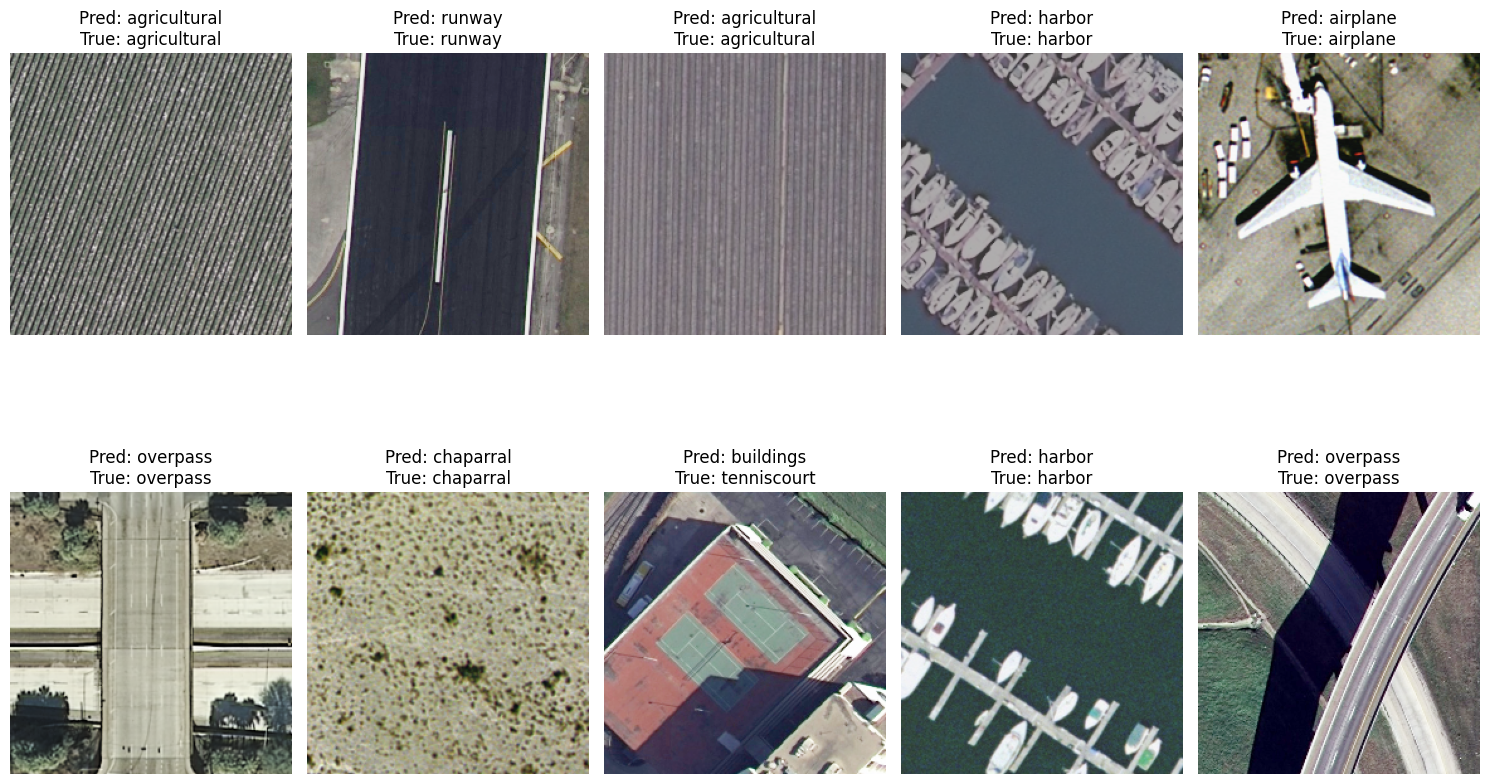

In [ ]:
# Only evaluate if we have a model
if model is not None:
    # Evaluate 10 images or fewer if there aren't enough
    num_samples = min(10, len(test_dataset))
    samples = random.sample(range(len(test_dataset)), num_samples)

    import matplotlib.pyplot as plt

    print(f"Evaluating {num_samples} images from the dataset...")
    plt.figure(figsize=(15, 10))

    for idx, i in enumerate(samples):
        # Get image and label
        image_tensor, label = test_dataset[i]

        # Process image for prediction
        input_tensor = image_tensor.unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)

        # Get class names
        pred_class = test_dataset.classes[pred.item()]
        true_class = test_dataset.classes[label]

        # Convert tensor to image for display
        img = image_tensor.permute(1, 2, 0).cpu().numpy()
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Display image
        plt.subplot(2, 5, idx+1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Cannot evaluate: model not available")

Calculating overall model accuracy...
Overall accuracy on test set: 90.90%


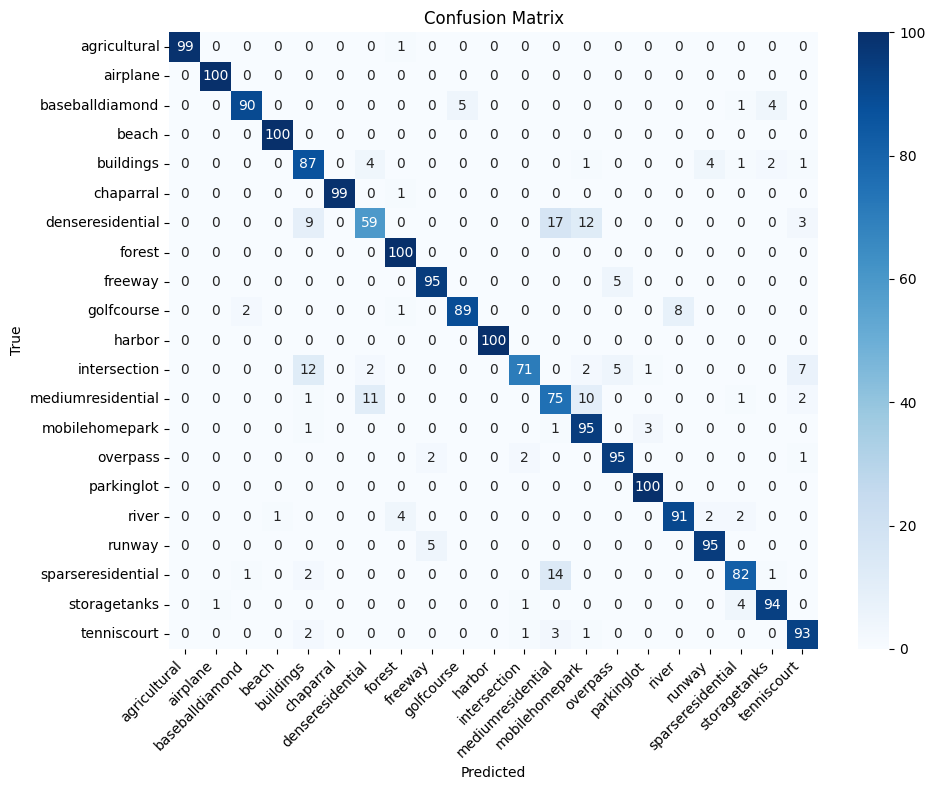

Evaluating 10 images from the dataset...


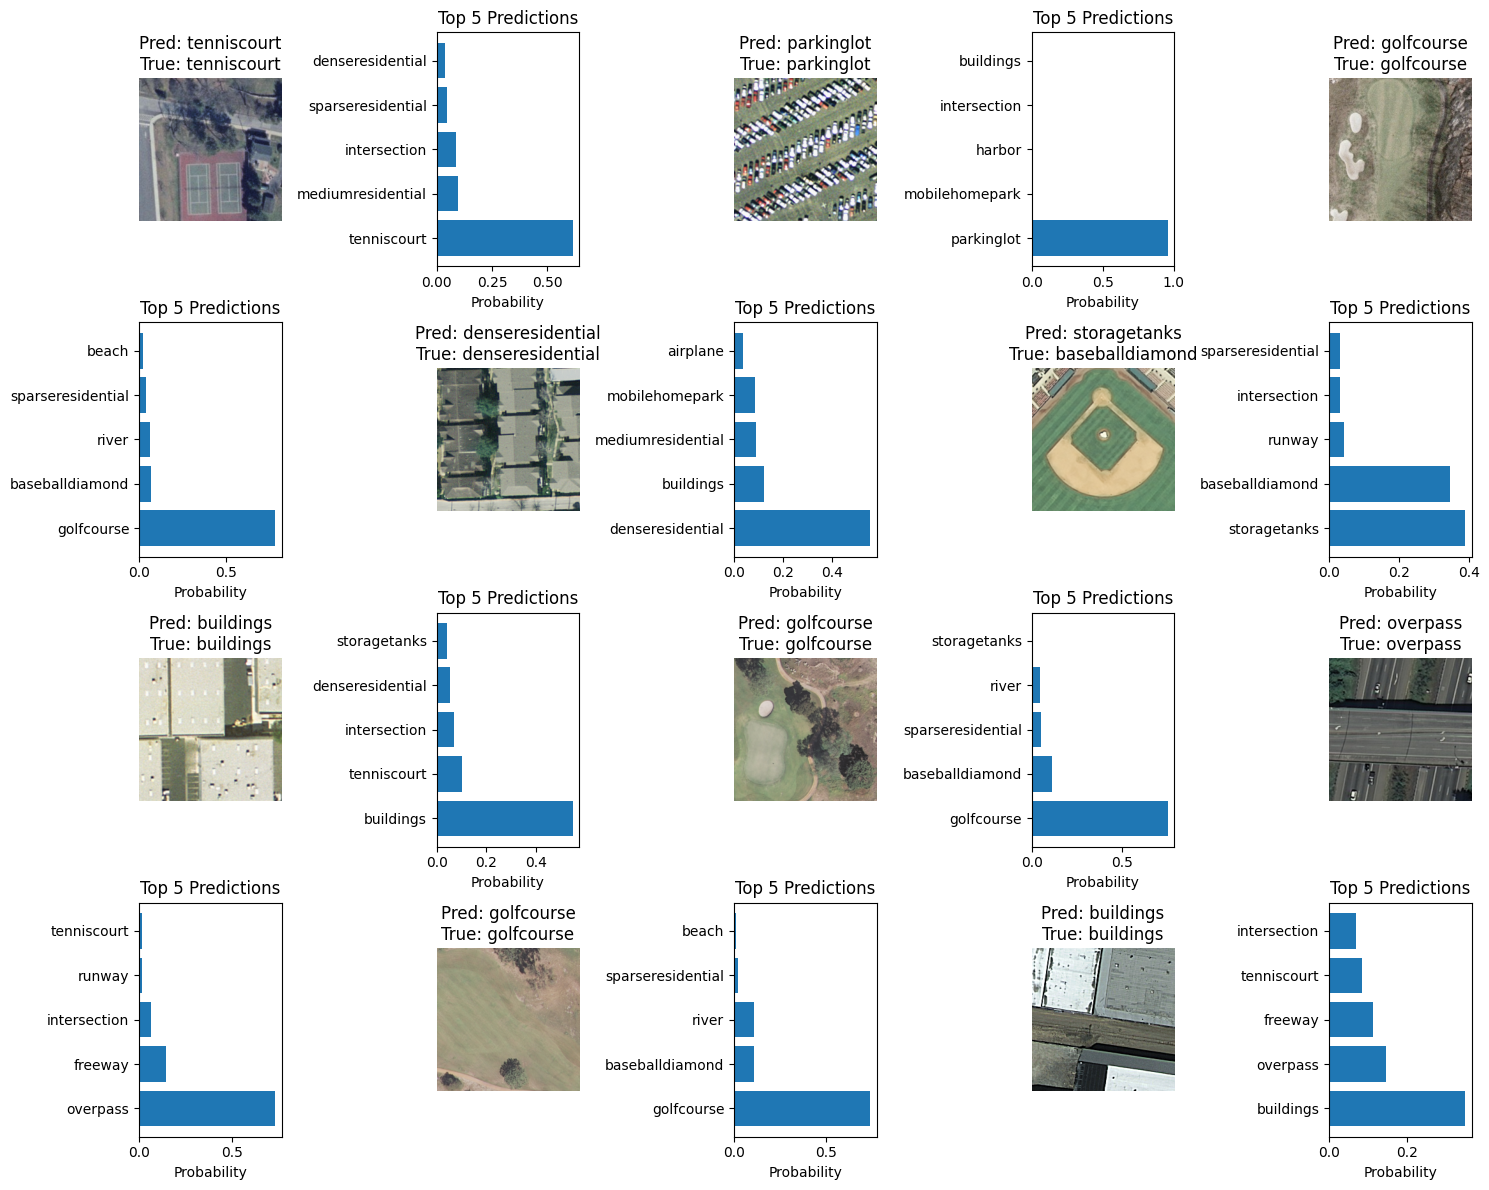

In [ ]:
# Only evaluate if we have a model
if model is not None:
    # Calculate overall accuracy on the test set
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    print("Calculating overall model accuracy...")
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Overall accuracy on test set: {accuracy:.2f}%")

    # Create confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Evaluate sample images
    num_samples = min(10, len(test_dataset))
    samples = random.sample(range(len(test_dataset)), num_samples)

    import matplotlib.pyplot as plt
    import torch.nn.functional as F

    print(f"Evaluating {num_samples} images from the dataset...")
    plt.figure(figsize=(15, 12))

    for idx, i in enumerate(samples):
        # Get image and label
        image_tensor, label = test_dataset[i]

        # Process image for prediction
        input_tensor = image_tensor.unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = F.softmax(output, dim=1)[0]
            _, pred = torch.max(output, 1)

        # Get class names
        pred_class = test_dataset.classes[pred.item()]
        true_class = test_dataset.classes[label]

        # Convert tensor to image for display
        img = image_tensor.permute(1, 2, 0).cpu().numpy()
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Display image
        plt.subplot(4, 5, idx*2+1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis('off')

        # Display softmax probabilities
        plt.subplot(4, 5, idx*2+2)

        # Get top 5 predictions
        top_p, top_class = torch.topk(probabilities, 5)
        top_p = top_p.cpu().numpy()
        top_class = top_class.cpu().numpy()

        class_names = [test_dataset.classes[i] for i in top_class]
        y_pos = np.arange(len(class_names))

        plt.barh(y_pos, top_p, align='center')
        plt.yticks(y_pos, class_names)
        plt.xlabel('Probability')
        plt.title('Top 5 Predictions')
        plt.tight_layout()

    plt.tight_layout()
    plt.show()
else:
    print("Cannot evaluate: model not available")

    #buildings, denseresidential, mediumresidential, sparserisdential, mobilehomepark

In [ ]:
type(test_dataset)

__main__.UCMercedDataset

# CP

In [ ]:
!pip install mapie -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 39.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split

class_names = test_dataset.classes

# Assuming test_dataset is your test dataset
calibration_dataset, testing_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42)

calibration_loader = DataLoader(calibration_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(testing_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Generating predictions"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

calibration_preds, calibration_labels, calibration_probs = get_predictions(model, calibration_loader, device)
test_preds, test_labels, test_probs = get_predictions(model, test_loader, device)

Generating predictions: 100%|██████████| 66/66 [04:02<00:00,  3.67s/it]


In [ ]:
#help(MapieClassifier)

In [ ]:
#que diferencias hay entre naive y score?

In [ ]:
import warnings
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score

def split_conformal_prediction(calibration_probs, calibration_labels, test_probs, alpha):
    """
    Manually implement Split Conformal Prediction.

    Parameters:
        calibration_probs: Predicted probabilities for the calibration set.
        calibration_labels: True labels for the calibration set.
        test_probs: Predicted probabilities for the test set.
        alpha: Significance level (e.g., 0.1, 0.05, 0.01).

    Returns:
        y_set: Prediction sets for the test set.
    """
    # Compute scores for the calibration set
    calibration_scores = 1 - calibration_probs[np.arange(len(calibration_labels)), calibration_labels]

    # Compute the quantile for the given alpha
    n_calibration = len(calibration_labels)
    quantile = np.ceil((n_calibration + 1) * (1 - alpha)) / n_calibration
    quantile = np.minimum(quantile, 1)  # Ensure quantile is not greater than 1

    # Compute prediction sets for the test set
    test_scores = 1 - test_probs
    y_set = test_scores <= np.quantile(calibration_scores, quantile)

    return y_set

def run_conformal_prediction(model, calibration_probs, calibration_labels, test_probs, test_labels, alphas):
    """
    Run conformal prediction with Split CP, APS, and RAPS for different alpha values.
    Store results in a DataFrame.

    Parameters:
        model: The trained model being used.
        calibration_probs: Predicted probabilities for the calibration set.
        calibration_labels: True labels for the calibration set.
        test_probs: Predicted probabilities for the test set.
        test_labels: True labels for the test set.
        alphas: List of alpha values to evaluate (e.g., [0.1, 0.05, 0.01]).

    Returns:
        A DataFrame containing results for all methods and alpha values.
    """
    # List of methods to evaluate
    methods = ["split_cp", "aps", "raps"]

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame(columns=["CP Method", "Alpha", "Empirical Coverage", "Mean Set Size", "Set Size Distribution"])

    # Suppress FutureWarnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Iterate over alpha values
    for alpha in alphas:
        print(f"Model: {model.__class__.__name__}")
        print(f"Conformal Prediction for alpha: {alpha}")
        print(f"Calibration set size: {len(calibration_labels)}")
        print(f"Test set size: {len(test_labels)}")
        print("-" * 50)

        # Iterate over different conformal prediction methods
        for method in methods:
            if method == "split_cp":
                # Manually implement Split Conformal Prediction
                y_set = split_conformal_prediction(calibration_probs, calibration_labels, test_probs, alpha)
            else:
                # Use MAPIE for APS and RAPS
                mapie = MapieClassifier(
                    estimator=None,
                    method=method,
                    cv="prefit",
                    random_state=42
                )

                # Fit MAPIE on the calibration set
                mapie.fit(calibration_probs, calibration_labels)

                # Predict on the test set
                y_pred, y_set = mapie.predict(test_probs, alpha=alpha)

                # Fix the shape of y_set
                y_set = np.squeeze(y_set, axis=-1)

            # Evaluate the results
            coverage = classification_coverage_score(test_labels, y_set)
            mean_width = classification_mean_width_score(y_set)

            # Calculate set size distribution
            set_sizes = np.sum(y_set, axis=1)
            set_size_distribution = {size: np.sum(set_sizes == size) for size in np.unique(set_sizes)}

            # Append results to the DataFrame
            results_df = pd.concat(
                [
                    results_df,
                    pd.DataFrame(
                        {
                            "CP Method": [method.upper()],
                            "Alpha": [alpha],
                            "Empirical Coverage": [coverage],
                            "Mean Set Size": [mean_width],
                            "Set Size Distribution": [set_size_distribution],
                        }
                    ),
                ],
                ignore_index=True,
            )

            print(f"Method: {method.upper()}")
            print(f"Coverage: {coverage:.2f}")
            print(f"Mean prediction set size: {mean_width:.2f}")
            print(f"Set size distribution: {set_size_distribution}")
            print("-" * 50)

    return results_df


# Example usage
alphas = [0.1, 0.05, 0.01]  # List of alpha values to evaluate
results_df = pd.DataFrame()

# Assuming calibration_probs, calibration_labels, test_probs, test_labels are already defined
results_df = run_conformal_prediction(model, calibration_probs, calibration_labels, test_probs, test_labels, alphas)

results_df

Model: ResNet
Conformal Prediction for alpha: 0.1
Calibration set size: 1050
Test set size: 1050
--------------------------------------------------
Method: SPLIT_CP
Coverage: 0.91
Mean prediction set size: 1.04
Set size distribution: {np.int64(0): np.int64(41), np.int64(1): np.int64(931), np.int64(2): np.int64(78)}
--------------------------------------------------
Method: APS
Coverage: 1.00
Mean prediction set size: 2.49
Set size distribution: {np.int64(1): np.int64(643), np.int64(2): np.int64(82), np.int64(3): np.int64(61), np.int64(4): np.int64(65), np.int64(5): np.int64(57), np.int64(6): np.int64(45), np.int64(7): np.int64(41), np.int64(8): np.int64(19), np.int64(9): np.int64(14), np.int64(10): np.int64(12), np.int64(11): np.int64(9), np.int64(12): np.int64(2)}
--------------------------------------------------
Method: RAPS
Coverage: 0.98
Mean prediction set size: 1.54
Set size distribution: {np.int64(1): np.int64(504), np.int64(2): np.int64(527), np.int64(3): np.int64(19)}
-------

,CP Method,Alpha,Empirical Coverage,Mean Set Size,Set Size Distribution
0,SPLIT_CP,0.10,0.912381,1.035238,"{0: 41, 1: 931, 2: 78}"
1,APS,0.10,0.996190,2.488571,"{1: 643, 2: 82, 3: 61, 4: 65, 5: 57, 6: 45, 7:..."
2,RAPS,0.10,0.980000,1.538095,"{1: 504, 2: 527, 3: 19}"
3,SPLIT_CP,0.05,0.944762,1.164762,"{0: 10, 1: 859, 2: 179, 3: 2}"
4,APS,0.05,0.999048,3.293333,"{1: 564, 2: 74, 3: 52, 4: 53, 5: 53, 6: 51, 7:..."
5,RAPS,0.05,0.989524,1.973333,"{1: 504, 2: 73, 3: 470, 4: 3}"
6,SPLIT_CP,0.01,0.986667,1.583810,"{1: 603, 2: 304, 3: 121, 4: 21, 5: 1}"
7,APS,0.01,1.000000,5.190476,"{1: 379, 2: 102, 3: 54, 4: 37, 5: 45, 6: 46, 7..."
8,RAPS,0.01,0.999048,4.037143,"{1: 340, 2: 112, 3: 63, 4: 43, 5: 44, 6: 42, 7..."


In [ ]:
df = results_df.copy()

expanded_rows = []
for _, row in df.iterrows():
    grouped_counts = {"0": 0, "1": 0, "2": 0, "3": 0, "4+": 0}
    for size, count in row["Set Size Distribution"].items():
        size_str = str(size)  # Ensure key exists
        if size <= 3:
            grouped_counts[size_str] += count
        else:
            grouped_counts["4+"] += count
    expanded_rows.append({"CP Method": row["CP Method"], "Alpha": row["Alpha"], **grouped_counts})

# Create a pivot table and reorder CP Methods
expanded_df = pd.DataFrame(expanded_rows)
expanded_df["CP Method"] = pd.Categorical(expanded_df["CP Method"], categories=["SPLIT_CP", "APS", "RAPS"], ordered=True)
expanded_df = expanded_df.sort_values(["CP Method", "Alpha"])

# Pivot table and transpose
pivot_table = expanded_df.pivot_table(index=["Alpha", "CP Method"], values=["0", "1", "2", "3", "4+"], aggfunc="sum")
pivot_table = pivot_table.T  # Transpose for better readability

pivot_table.T

0    1    2    3   4+
Alpha CP Method                        
0.01  SPLIT_CP    0  603  304  121   22
      APS         0  379  102   54  515
      RAPS        0  340  112   63  535
0.05  SPLIT_CP   10  859  179    2    0
      APS         0  564   74   52  360
      RAPS        0  504   73  470    3
0.10  SPLIT_CP   41  931   78    0    0
      APS         0  643   82   61  264
      RAPS        0  504  527   19    0

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Convert Alpha to string for better legend
results_df['Alpha'] = results_df['Alpha'].astype(str)

# Create interactive plotly figure
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Empirical Coverage by Method and Alpha",
                                    "Mean Set Size by Method and Alpha"),
                    horizontal_spacing=0.1)

# Define custom colors that match the alpha values
colors = {
    '0.1': '#440154',  # Dark purple for 0.1 (highest confidence)
    '0.05': '#21918c', # Teal for 0.05
    '0.01': '#fde725'  # Yellow for 0.01 (lowest confidence)
}

# Add first subplot - Empirical Coverage
for alpha in ['0.1', '0.05', '0.01']:
    df_subset = results_df[results_df['Alpha'] == alpha]

    fig.add_trace(
        go.Bar(
            x=df_subset['CP Method'],
            y=df_subset['Empirical Coverage'],
            name=f'Alpha = {alpha}',
            marker_color=colors[alpha],
            hovertemplate='<b>%{x}</b><br>Coverage: %{y:.4f}<br>Alpha: ' + alpha,
            showlegend=True
        ),
        row=1, col=1
    )

# Ading reference lines for thresholds that match alpha colors without adding to legend
thresholds = [
    (0.90, colors['0.1']),
    (0.95, colors['0.05']),
    (0.99, colors['0.01'])
]

for threshold, color in thresholds:
    fig.add_trace(
        go.Scatter(
            x=["SPLIT_CP", "APS", "RAPS"],
            y=[threshold] * 4,
            mode='lines',
            line=dict(color=color, dash='dash', width=2),
            hoverinfo='text',
            text=f'Threshold: {threshold}',
            showlegend=False
        ),
        row=1, col=1
    )

# Add second subplot - Mean Set Size
for alpha in ['0.1', '0.05', '0.01']:
    df_subset = results_df[results_df['Alpha'] == alpha]

    fig.add_trace(
        go.Bar(
            x=df_subset['CP Method'],
            y=df_subset['Mean Set Size'],
            name=f'Alpha = {alpha}',
            marker_color=colors[alpha],
            hovertemplate='<b>%{x}</b><br>Mean Set Size: %{y:.4f}<br>Alpha: ' + alpha,
            showlegend=False
        ),
        row=1, col=2
    )

# Update layout
fig.update_layout(
    title_text='Comparison of Confidence Prediction Methods',
    height=600,
    width=1000,
    legend_title_text='Alpha',
    template='plotly_white',
    barmode='group'
)

# Update y-axes
fig.update_yaxes(title_text='Empirical Coverage', range=[0.9, 1.01], row=1, col=1)
fig.update_yaxes(title_text='Mean Set Size', row=1, col=2)
fig.update_xaxes(title_text='CP Method', row=1, col=1)
fig.update_xaxes(title_text='CP Method', row=1, col=2)

fig.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_top_sets(test_images, test_labels, y_set, class_names, top_k=5):
    """
    Visualize the top-k prediction sets with the largest set sizes.

    Parameters:
        test_images: The test images (or data) to visualize.
        test_labels: The true labels for the test set.
        y_set: The prediction sets for the test set.
        class_names: List of class names for labeling.
        top_k: Number of top sets to visualize (default: 5).
    """
    # Compute set sizes
    set_sizes = np.sum(y_set, axis=1)

    # Get indices of the top-k largest sets
    top_indices = np.argsort(set_sizes)[-top_k:][::-1]

    # Plot the top-k sets in 1 column
    fig, axes = plt.subplots(top_k, 1, figsize=(8, 5 * top_k))  # 1 column, adjust figure size
    if top_k == 1:
        axes = [axes]  # Ensure axes is a list even for top_k=1

    for i, idx in enumerate(top_indices):
        ax = axes[i]
        # Convert image from (C, H, W) to (H, W, C) for visualization
        image = np.transpose(test_images[idx], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])  # Standard ImageNet mean
        std = np.array([0.229, 0.224, 0.225])   # Standard ImageNet std
        image = image * std + mean  # Reverse normalization
        image = np.clip(image, 0, 1)  # Clip values to [0, 1] for visualization

        ax.imshow(image)  # Original colors display
        true_label = class_names[test_labels[idx]]
        predicted_set = np.where(y_set[idx])[0]
        predicted_labels = [class_names[p] for p in predicted_set]
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_labels}", fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Extract test_images and test_labels from test_loader
test_images = []
test_labels = []

for images, labels in test_loader:
    test_images.append(images)
    test_labels.append(labels)

# Concatenate batches into single tensors
test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)

# Convert tensors to NumPy arrays (if needed)
test_images = test_images.numpy()
test_labels = test_labels.numpy()

# Define class_names
class_names = test_dataset.classes

# Visualize the top 5 sets
visualize_top_sets(test_images, test_labels, y_set, class_names, top_k=35)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Denormalize a normalized image tensor.
    """
    image = image.numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
    image = std * image + mean  # Denormalize
    image = np.clip(image, 0, 1)  # Clip to valid range
    return image

def visualize_predicted_sets(test_dataset, true_labels, predicted_sets, softmax_probs, class_names, num_images=5):
    """
    Visualize images with their predicted sets and softmax probabilities.

    Parameters:
        test_dataset: PyTorch dataset or subset containing test images.
        true_labels: Array of true labels for the test images.
        predicted_sets: Array of predicted sets (shape: [n_samples, n_classes]).
        softmax_probs: Array of softmax probabilities (shape: [n_samples, n_classes]).
        class_names: List of class names corresponding to the labels.
        num_images: Number of images to visualize (default: 5).
    """
    plt.figure(figsize=(15, 5 * num_images))  # Increase figure size for better visibility
    for i in range(num_images):
        # Get the image, true label, predicted set, and softmax probabilities
        image, _ = test_dataset[i]  # Get the image and ignore the label (already in true_labels)
        true_label = true_labels[i]
        predicted_set = predicted_sets[i]
        softmax_prob = softmax_probs[i]

        # Denormalize the image
        image = denormalize(image)

        # Get the indices of classes in the predicted set, sorted by softmax probability
        sorted_indices = np.argsort(-softmax_prob)  # Sort in descending order
        predicted_classes = [idx for idx in sorted_indices if predicted_set[idx]]

        # Plot the image
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image)
        plt.axis("off")

        # Display the predicted set and softmax probabilities
        title = "Predicted Set:\n"
        y_offset = 0.9  # Starting y-position for text (relative to the subplot)
        for idx in predicted_classes:
            class_name = class_names[idx]
            prob = softmax_prob[idx]
            if idx == true_label:
                # Highlight true class in green
                plt.text(0.5, y_offset, f"[{class_name}: {prob:.2f}] (True Class)",
                         fontsize=12, color="green", ha="center", transform=plt.gca().transAxes)
            else:
                # Other classes in black
                plt.text(0.5, y_offset, f"{class_name}: {prob:.2f}",
                         fontsize=12, color="black", ha="center", transform=plt.gca().transAxes)
            y_offset -= 0.1

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Denormalize a normalized image tensor.
    """
    image = image.numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
    image = std * image + mean  # Denormalize
    image = np.clip(image, 0, 1)  # Clip to valid range
    return image

def visualize_predicted_sets(test_dataset, true_labels, predicted_sets, softmax_probs, class_names, num_images=5):
    """
    Visualize images with their predicted sets and softmax probabilities.

    Parameters:
        test_dataset: PyTorch dataset or subset containing test images.
        true_labels: Array of true labels for the test images.
        predicted_sets: Array of predicted sets (shape: [n_samples, n_classes]).
        softmax_probs: Array of softmax probabilities (shape: [n_samples, n_classes]).
        class_names: List of class names corresponding to the labels.
        num_images: Number of images to visualize (default: 5).
    """
    plt.figure(figsize=(15, 5 * num_images))  # Increase figure size for better visibility
    for i in range(num_images):
        # Get the image, true label, predicted set, and softmax probabilities
        image, _ = test_dataset[i]  # Get the image and ignore the label (already in true_labels)
        true_label = true_labels[i]
        predicted_set = predicted_sets[i]
        softmax_prob = softmax_probs[i]

        # Denormalize the image
        image = denormalize(image)

        # Create a subplot for the image and text
        ax = plt.subplot(num_images, 1, i + 1)

        # Display the image on the left
        plt.imshow(image)
        plt.axis("off")

        # Display the predicted set and softmax probabilities on the right
        text = "Predicted Set:\n"
        for idx in np.argsort(-softmax_prob):  # Sort by descending probability
            if predicted_set[idx]:  # Only include classes in the predicted set
                class_name = class_names[idx]
                prob = softmax_prob[idx]
                if idx == true_label:
                    text += f"[{class_name}: {prob:.2f}] (True Class)\n"  # Highlight true class in green
                else:
                    text += f"{class_name}: {prob:.2f}\n"

        # Add text to the right of the image
        plt.text(1.1, 0.5, text, fontsize=12, color="black", ha="left", va="center", transform=ax.transAxes)

    # Adjust layout to prevent overlap
    plt.subplots_adjust(wspace=0.5)  # Add space between subplots
    plt.tight_layout()
    plt.show()

In [ ]:
# Call the visualization function
visualize_predicted_sets(test_dataset, test_labels, y_set, test_probs, class_names, num_images=5)

## Testing class conditional

In [2]:
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score

def run_class_conditional_conformal_prediction(model, calibration_probs, calibration_labels, test_probs, test_labels, alphas, test_dataset):
    """
    Run class-conditional conformal prediction with MAPIE for different methods and alpha values.

    Parameters:
        model: The trained model being used.
        calibration_probs: Predicted probabilities for the calibration set.
        calibration_labels: True labels for the calibration set.
        test_probs: Predicted probabilities for the test set.
        test_labels: True labels for the test set.
        alphas: List of alpha values to evaluate (e.g., [0.1, 0.05, 0.01]).
        test_dataset: Dataset containing class names.

    Returns:
        A DataFrame containing results for all methods, alpha values, and classes.
    """
    methods = ["naive", "aps", "raps"]
    class_results_df = pd.DataFrame(columns=["CP Method", "Alpha", "Class", "Empirical Coverage", "Mean Set Size", "Class Size"])
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Get class names from the dataset
    class_names = test_dataset.classes

    for alpha in alphas:
        print(f"Model: {model.__class__.__name__}")
        print(f"Class-Conditional Conformal Prediction for alpha: {alpha}")
        print(f"Calibration set size: {len(calibration_labels)}")
        print(f"Test set size: {len(test_labels)}")
        print("-" * 50)

        for method in methods:
            print(f"Method: {method.upper()}")

            # Fit MAPIE on the full calibration set
            mapie = MapieClassifier(estimator=None, method=method, cv="prefit", random_state=42)
            mapie.fit(calibration_probs, calibration_labels)

            # Predict on the full test set
            y_pred, y_set = mapie.predict(test_probs, alpha=alpha)
            y_set = np.squeeze(y_set, axis=-1)

            # Calculate overall metrics
            overall_coverage = classification_coverage_score(test_labels, y_set)
            overall_mean_width = classification_mean_width_score(y_set)

            # Add overall results
            class_results_df = pd.concat(
                [
                    class_results_df,
                    pd.DataFrame(
                        {
                            "CP Method": [method.upper()],
                            "Alpha": [alpha],
                            "Class": ["Overall"],
                            "Empirical Coverage": [overall_coverage],
                            "Mean Set Size": [overall_mean_width],
                            "Class Size": [len(test_labels)]
                        }
                    )
                ],
                ignore_index=True
            )

            # Evaluate per-class performance
            for class_idx, class_name in enumerate(class_names):
                # Get indices for this class in test set
                test_class_indices = np.where(test_labels == class_idx)[0]

                if len(test_class_indices) == 0:
                    print(f"No test samples for class {class_name}")
                    continue

                # Extract test data for this class
                test_class_labels = test_labels[test_class_indices]
                y_set_class = y_set[test_class_indices]

                # Calculate class-specific metrics
                class_coverage = classification_coverage_score(test_class_labels, y_set_class)
                class_mean_width = classification_mean_width_score(y_set_class)

                # Add class-specific results
                class_results_df = pd.concat(
                    [
                        class_results_df,
                        pd.DataFrame(
                            {
                                "CP Method": [method.upper()],
                                "Alpha": [alpha],
                                "Class": [class_name],
                                "Empirical Coverage": [class_coverage],
                                "Mean Set Size": [class_mean_width],
                                "Class Size": [len(test_class_indices)]
                            }
                        )
                    ],
                    ignore_index=True
                )

            print("-" * 40)

    return class_results_df


alphas = [0.1, 0.05, 0.01]
class_results_df = run_class_conditional_conformal_prediction(model, calibration_probs, calibration_labels, test_probs, test_labels, alphas, test_dataset)

class_results_df

ModuleNotFoundError: No module named 'mapie'

In [ ]:
filtered_df = class_results_df[class_results_df['Class'].isin(['Overall','buildings', 'denseresidential', 'mediumresidential', 'sparseresidential', 'mobilehomepark'])]
#filtered_df

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

def visualize_selective_cp_results(filtered_df, class_names):
    # Plot 1: Coverage by method, alpha and classes
    fig1 = go.Figure()

    # Create a continuous color scale based on viridis
    unique_classes = filtered_df['Class'].unique()
    color_scale = px.colors.sequential.Viridis
    class_colors = {
        cls: color_scale[i * len(color_scale) // len(unique_classes)]
        for i, cls in enumerate(unique_classes)
    }

    # Override for Overall
    if 'Overall' in unique_classes:
        class_colors['Overall'] = 'black'

    for cls in unique_classes:
        for method in filtered_df['CP Method'].unique():
            subset = filtered_df[(filtered_df['Class'] == cls) & (filtered_df['CP Method'] == method)]
            if subset.empty:
                continue
            line_style = 'solid' if cls == 'Overall' else 'dot'
            width = 3 if cls == 'Overall' else 1.5
            fig1.add_trace(go.Scatter(
                x=subset['Alpha'],
                y=subset['Empirical Coverage'],
                mode='lines+markers',
                name=f"{cls} - {method}",
                line=dict(color=class_colors[cls], dash=line_style, width=width),
                marker=dict(size=8)
            ))

    # Add target coverage lines
    for alpha in filtered_df['Alpha'].unique():
        fig1.add_shape(
            type='line',
            x0=alpha, x1=alpha,
            y0=0.9, y1=1-alpha,
            line=dict(color='red', width=1, dash='dash')
        )
        # Add annotation for target coverage
        fig1.add_annotation(
            x=alpha, y=1-alpha,
            text=f"Target: {1-alpha:.2f}",
            showarrow=True, arrowhead=1, ax=40, ay=-30
        )

    fig1.update_layout(
        title='Empirical Coverage by Method and Alpha',
        xaxis_title='Alpha',
        yaxis_title='Empirical Coverage',
        yaxis=dict(range=[0.9, 1.01]),
        xaxis=dict(
            tickmode='array',
            tickvals=sorted(filtered_df['Alpha'].unique()),
            ticktext=[f"{alpha}" for alpha in sorted(filtered_df['Alpha'].unique())]
        ),
        legend=dict(
            yanchor="top", y=0.99,
            xanchor="left", x=0.01
        )
    )

    # Plot 2: Mean set size comparison
    fig2 = go.Figure()
    for method in filtered_df['CP Method'].unique():
        method_df = filtered_df[(filtered_df['CP Method'] == method) & (filtered_df['Alpha'] == 0.05)]
        if method_df.empty:
            continue
        # Sort by set size for better visualization
        method_df = method_df.sort_values('Mean Set Size', ascending=False)
        fig2.add_trace(go.Bar(
            y=method_df['Class'],
            x=method_df['Mean Set Size'],
            name=method,
            orientation='h',
            marker=dict(
                color=[class_colors[cls] for cls in method_df['Class']],
                line=dict(width=1, color='#333333')
        )))

    fig2.update_layout(
        title='Mean Set Size by Class (α=0.05)',
        xaxis_title='Mean Set Size',
        yaxis_title='Class',
        barmode='group',
        height=600,
        legend=dict(
            orientation="h",
            yanchor="bottom", y=1.02,
            xanchor="right", x=1
        )
    )

    # Plot 3: "Efficiency" comparison (adding an additional insightful plot)
    fig3 = go.Figure()

    # Calculate "Efficiency" as empirical coverage / mean set size
    efficiency_df = filtered_df.copy()
    efficiency_df['Efficiency'] = efficiency_df['Empirical Coverage'] / efficiency_df['Mean Set Size']

    for method in efficiency_df['CP Method'].unique():
        for alpha in sorted(efficiency_df['Alpha'].unique()):
            subset = efficiency_df[(efficiency_df['CP Method'] == method) &
                                   (efficiency_df['Alpha'] == alpha) &
                                   (efficiency_df['Class'] != 'Overall')]
            if subset.empty:
                continue

            fig3.add_trace(go.Box(
                y=subset['Efficiency'],
                name=f"{method} (α={alpha})",
                boxpoints='all',
                jitter=0.3,
                pointpos=-1.8,
                marker=dict(
                    color=px.colors.qualitative.Plotly[list(efficiency_df['CP Method'].unique()).index(method)]
                )
            ))

    fig3.update_layout(
        title='Validity-Precision tradeoff (Coverage/Set Size) by Alpha',
        xaxis_title='CP Method and Alpha',
        yaxis_title='Efficiency (Coverage/Set Size)',
        boxmode='group',
        height=500
    )

    return fig1, fig2, fig3


fig1, fig2, fig3 = visualize_selective_cp_results(filtered_df, class_names)
fig1.show()
fig2.show()
fig3.show()

## checking class cond implementation (ok)

In [ ]:
class ClassConditionalConformalPredictor:
    def __init__(self, base_model=None, class_names=None):
        self.base_model = base_model
        self.class_thresholds = {}
        self.classes_ = None
        self.class_names = class_names  # Added class_names parameter

    def fit(self, X_cal, y_cal, alpha=0.1):
        # Store all possible classes
        self.classes_ = np.unique(y_cal)
        n_classes = len(self.classes_)

        # If class_names not provided, use default indices as names
        if self.class_names is None:
            self.class_names = {cls: str(cls) for cls in self.classes_}

        # Get probabilities if X_cal is features, otherwise use directly
        if hasattr(self.base_model, 'predict_proba') and not X_cal.shape[1] == n_classes:
            cal_probs = self.base_model.predict_proba(X_cal)
        else:
            cal_probs = X_cal

        # For each class, calculate class-specific threshold
        for class_idx in self.classes_:
            # Get indices of examples belonging to this class
            class_indices = np.where(y_cal == class_idx)[0]

            if len(class_indices) == 0:
                self.class_thresholds[class_idx] = 0.0
                continue

            # Calculate nonconformity scores for this class
            class_scores = 1 - cal_probs[class_indices, class_idx]

            # Calculate the quantile for this class with finite sample correction
            q = (len(class_indices) + 1) * (1 - alpha) / len(class_indices)

            # For very small alpha values and small calibration sets, q might exceed 1
            if len(class_indices) <= 1/(1-alpha) - 1:
                # If calibration set is too small for the given alpha, use the max score
                self.class_thresholds[class_idx] = np.max(class_scores)
            else:
                # Otherwise use the properly calculated quantile
                self.class_thresholds[class_idx] = np.quantile(class_scores, min(q, 1.0))

        # Calculate overall threshold for standard conformal prediction
        overall_scores = np.array([1 - cal_probs[i, y] for i, y in enumerate(y_cal)])

        # Similar logic for overall threshold
        q_overall = (len(y_cal) + 1) * (1 - alpha) / len(y_cal)

        if len(y_cal) <= 1/(1-alpha) - 1:
            self.class_thresholds['overall'] = np.max(overall_scores)
        else:
            self.class_thresholds['overall'] = np.quantile(overall_scores, min(q_overall, 1.0))

        return self

    def predict(self, X_test):
        n_classes = len(self.classes_)

        # Get probabilities if X_test is features, otherwise use directly
        if hasattr(self.base_model, 'predict_proba') and not X_test.shape[1] == n_classes:
            test_probs = self.base_model.predict_proba(X_test)
        else:
            test_probs = X_test

        n_test = len(X_test)

        # Class conditional sets
        class_conditional_sets = np.zeros((n_test, n_classes), dtype=bool)
        # Standard CP sets
        overall_sets = np.zeros((n_test, n_classes), dtype=bool)

        for i in range(n_test):
            for j, class_idx in enumerate(self.classes_):
                # Class conditional prediction sets
                nonconf_score = 1 - test_probs[i, j]
                if nonconf_score <= self.class_thresholds[class_idx]:
                    class_conditional_sets[i, j] = True

                # Standard CP prediction sets
                if 1 - test_probs[i, j] <= self.class_thresholds['overall']:
                    overall_sets[i, j] = True

        return class_conditional_sets, overall_sets

    def evaluate(self, X_test, y_test):
        """
        Evaluate the conformal predictor on test data.
        """
        class_conditional_sets, overall_sets = self.predict(X_test)

        results = []

        # Evaluate per-class performance for both methods
        for class_idx in self.classes_:
            class_indices = np.where(y_test == class_idx)[0]

            if len(class_indices) == 0:
                continue

            # Class Conditional performance for this class
            cc_class_coverage = np.mean([class_conditional_sets[i, y_test[i]] for i in class_indices])
            cc_class_size = np.mean(np.sum(class_conditional_sets[class_indices], axis=1))

            # Standard CP performance for this class
            std_class_coverage = np.mean([overall_sets[i, y_test[i]] for i in class_indices])
            std_class_size = np.mean(np.sum(overall_sets[class_indices], axis=1))

            # Use class_names instead of raw class index
            class_name = self.class_names[class_idx]

            results.append({
                "Method": "Class Conditional CP",
                "Class": class_name,
                "Empirical Coverage": cc_class_coverage,
                "Mean Set Size": cc_class_size,
                "Class Size": len(class_indices)
            })

            results.append({
                "Method": "Standard CP",
                "Class": class_name,
                "Empirical Coverage": std_class_coverage,
                "Mean Set Size": std_class_size,
                "Class Size": len(class_indices)
            })

        return pd.DataFrame(results)

def run_with_precomputed_probs(model, cal_probs, cal_labels, test_probs, test_labels, alpha=0.1, class_names=None):
    """
    Run class-conditional CP with precomputed probabilities.
    """
    # Initialize with None as the base model since we use precomputed probabilities
    cccp = ClassConditionalConformalPredictor(base_model=None, class_names=class_names)
    cccp.fit(cal_probs, cal_labels, alpha=alpha)

    # Evaluate on test data
    results = cccp.evaluate(test_probs, test_labels)

    return results

def run_class_conditional_conformal_prediction_improved(model, calibration_probs, calibration_labels,
                                                       test_probs, test_labels, alphas, class_names=None,
                                                       test_dataset=None):
    """
    Run class-conditional CP with multiple alpha values.
    """
    all_results = []

    for alpha in alphas:
        print(f"Running Class-Conditional Conformal Prediction for alpha: {alpha}")
        print(f"Calibration set size: {len(calibration_labels)}")
        print(f"Test set size: {len(test_labels)}")
        print("-" * 50)

        # Run the class-conditional CP
        results = run_with_precomputed_probs(
            model=None,
            cal_probs=calibration_probs,
            cal_labels=calibration_labels,
            test_probs=test_probs,
            test_labels=test_labels,
            alpha=alpha,
            class_names=class_names  # Pass class_names parameter
        )

        # Add alpha column
        results["Alpha"] = alpha

        all_results.append(results)

    # Combine all results
    final_results = pd.concat(all_results, ignore_index=True)

    # Reorganizing columns
    final_results = final_results[["Method", "Alpha", "Class", "Empirical Coverage", "Mean Set Size", "Class Size"]]

    return final_results

In [ ]:
class_names = test_dataset.classes
results = run_class_conditional_conformal_prediction_improved(
    model, calibration_probs, calibration_labels, test_probs, test_labels, alphas, class_names
)
results[results['Alpha'] == 0.1]

Running Class-Conditional Conformal Prediction for alpha: 0.1
Calibration set size: 1050
Test set size: 1050
--------------------------------------------------
Running Class-Conditional Conformal Prediction for alpha: 0.05
Calibration set size: 1050
Test set size: 1050
--------------------------------------------------
Running Class-Conditional Conformal Prediction for alpha: 0.01
Calibration set size: 1050
Test set size: 1050
--------------------------------------------------


,Method,Alpha,Class,Empirical Coverage,Mean Set Size,Class Size
0,Class Conditional CP,0.1,agricultural,0.955556,0.955556,45
1,Standard CP,0.1,agricultural,0.977778,0.977778,45
2,Class Conditional CP,0.1,airplane,0.824561,0.824561,57
3,Standard CP,0.1,airplane,1.000000,1.000000,57
4,Class Conditional CP,0.1,baseballdiamond,0.944444,1.203704,54
5,Standard CP,0.1,baseballdiamond,0.962963,1.111111,54
6,Class Conditional CP,0.1,beach,0.946429,0.964286,56
7,Standard CP,0.1,beach,1.000000,1.000000,56
8,Class Conditional CP,0.1,buildings,0.823529,1.137255,51
9,Standard CP,0.1,buildings,0.803922,0.882353,51


### Class cond with RAPS

In [ ]:
class ClassConditionalConformalPredictor:
    def __init__(self, base_model=None, class_names=None):
        self.base_model = base_model
        self.class_thresholds = {}
        self.classes_ = None
        self.class_names = class_names

    def fit(self, X_cal, y_cal, alpha=0.1):
        self.classes_ = np.unique(y_cal)
        n_classes = len(self.classes_)

        if self.class_names is None:
            self.class_names = {cls: str(cls) for cls in self.classes_}

        if hasattr(self.base_model, 'predict_proba') and not X_cal.shape[1] == n_classes:
            cal_probs = self.base_model.predict_proba(X_cal)
        else:
            cal_probs = X_cal

        # Class Conditional RAPS
        for class_idx in self.classes_:
            class_indices = np.where(y_cal == class_idx)[0]
            if len(class_indices) == 0:
                self.class_thresholds[class_idx] = 0.0
                continue

            # RAPS scoring (hardcoded params)
            class_scores = [1 - cal_probs[i, class_idx] + 0.5 * max(0, (np.where(np.argsort(cal_probs[i])[::-1] == class_idx)[0][0] - 5))
                          for i in class_indices]

            q = (len(class_indices) + 1) * (1 - alpha) / len(class_indices)
            self.class_thresholds[class_idx] = np.quantile(class_scores, min(q, 1.0)) if len(class_indices) > 1/(1-alpha) - 1 else np.max(class_scores)

        # Standard RAPS
        overall_scores = [1 - cal_probs[i, y] + 0.5 * max(0, (np.where(np.argsort(cal_probs[i])[::-1] == y)[0][0] - 5))
                         for i, y in enumerate(y_cal)]

        q_overall = (len(y_cal) + 1) * (1 - alpha) / len(y_cal)
        self.class_thresholds['overall'] = np.quantile(overall_scores, min(q_overall, 1.0)) if len(y_cal) > 1/(1-alpha) - 1 else np.max(overall_scores)

        return self

    def predict(self, X_test):
        n_classes = len(self.classes_)
        if hasattr(self.base_model, 'predict_proba') and not X_test.shape[1] == n_classes:
            test_probs = self.base_model.predict_proba(X_test)
        else:
            test_probs = X_test

        n_test = len(X_test)
        class_conditional_sets = np.zeros((n_test, n_classes), dtype=bool)
        overall_sets = np.zeros((n_test, n_classes), dtype=bool)

        for i in range(n_test):
            for j, class_idx in enumerate(self.classes_):
                # RAPS score calculation
                raps_score = 1 - test_probs[i, j] + 0.5 * max(0, (np.where(np.argsort(test_probs[i])[::-1] == class_idx)[0][0] - 5))

                class_conditional_sets[i, j] = raps_score <= self.class_thresholds[class_idx]
                overall_sets[i, j] = raps_score <= self.class_thresholds['overall']

        return class_conditional_sets, overall_sets

    def evaluate(self, X_test, y_test):
        cc_sets, std_sets = self.predict(X_test)
        results = []

        for class_idx in self.classes_:
            class_indices = np.where(y_test == class_idx)[0]
            if len(class_indices) == 0:
                continue

            # Convert generator to list before np.mean()
            cc_coverage = np.mean([cc_sets[i, y_test[i]] for i in class_indices])
            cc_size = np.mean(np.sum(cc_sets[class_indices], axis=1))

            std_coverage = np.mean([std_sets[i, y_test[i]] for i in class_indices])
            std_size = np.mean(np.sum(std_sets[class_indices], axis=1))

            results.extend([{
                "Method": "Class Conditional RAPS",
                "Class": self.class_names[class_idx],
                "Empirical Coverage": cc_coverage,
                "Mean Set Size": cc_size,
                "Class Size": len(class_indices)
            }, {
                "Method": "Standard RAPS",
                "Class": self.class_names[class_idx],
                "Empirical Coverage": std_coverage,
                "Mean Set Size": std_size,
                "Class Size": len(class_indices)
            }])

        return pd.DataFrame(results)

In [ ]:
cccp = ClassConditionalConformalPredictor(base_model=None, class_names=class_names)
cccp.fit(calibration_probs, calibration_labels, alpha=0.1)
resultados = cccp.evaluate(test_probs, test_labels)


resultados.head(20)

,Method,Class,Empirical Coverage,Mean Set Size,Class Size
0,Class Conditional RAPS,agricultural,0.955556,0.955556,45
1,Standard RAPS,agricultural,0.977778,0.977778,45
2,Class Conditional RAPS,airplane,0.824561,0.824561,57
3,Standard RAPS,airplane,1.000000,1.000000,57
4,Class Conditional RAPS,baseballdiamond,0.944444,1.203704,54
5,Standard RAPS,baseballdiamond,0.962963,1.111111,54
6,Class Conditional RAPS,beach,0.946429,0.964286,56
7,Standard RAPS,beach,1.000000,1.000000,56
8,Class Conditional RAPS,buildings,0.823529,1.137255,51
9,Standard RAPS,buildings,0.803922,0.882353,51


In [ ]:
# After getting your results
resultados = cccp.evaluate(test_probs, test_labels)

# Add comparison column
resultados['CC_RAPS_Better'] = False  # Initialize column

# Iterate through classes to compare performance
for class_idx in cccp.classes_:
    class_name = cccp.class_names[class_idx]

    # Get rows for this class
    class_rows = resultados[resultados['Class'] == class_name]

    # Extract metrics
    cc_metrics = class_rows[class_rows['Method'] == 'Class Conditional RAPS'].iloc[0]
    std_metrics = class_rows[class_rows['Method'] == 'Standard RAPS'].iloc[0]

    # Determine which performed better (higher coverage with smaller set size is better)
    better_coverage = cc_metrics['Empirical Coverage'] > std_metrics['Empirical Coverage']
    smaller_size = cc_metrics['Mean Set Size'] < std_metrics['Mean Set Size']

    # Update the boolean column
    resultados.loc[(resultados['Class'] == class_name) &
                  (resultados['Method'] == 'Class Conditional RAPS'),
                  'CC_RAPS_Better'] = smaller_size

resultados

,Method,Class,Empirical Coverage,Mean Set Size,Class Size,CC_RAPS_Better
0,Class Conditional RAPS,agricultural,0.955556,0.955556,45,True
1,Standard RAPS,agricultural,0.977778,0.977778,45,False
2,Class Conditional RAPS,airplane,0.824561,0.824561,57,True
3,Standard RAPS,airplane,1.000000,1.000000,57,False
4,Class Conditional RAPS,baseballdiamond,0.944444,1.203704,54,False
5,Standard RAPS,baseballdiamond,0.962963,1.111111,54,False
6,Class Conditional RAPS,beach,0.946429,0.964286,56,True
7,Standard RAPS,beach,1.000000,1.000000,56,False
8,Class Conditional RAPS,buildings,0.823529,1.137255,51,False
9,Standard RAPS,buildings,0.803922,0.882353,51,False


In [ ]:
# Remember to check results standards vs class-cond!!

In [ ]:
class ConformalPredictor:
    def __init__(self):
        self.global_threshold = None
        self.class_thresholds = {}
        self.classes_ = None

    def fit(self, X_cal, y_cal, alpha=0.1):
        self.classes_ = np.unique(y_cal)

        # Global threshold for Standard Conformal Prediction
        global_scores = [1 - X_cal[i, y] for i, y in enumerate(y_cal)]
        q_global = (len(y_cal) + 1) * (1 - alpha) / len(y_cal)
        self.global_threshold = np.quantile(global_scores, min(q_global, 1.0))

        # RAPS with class-conditional thresholds
        for class_idx in self.classes_:
            class_indices = np.where(y_cal == class_idx)[0]
            class_scores = [
                1 - X_cal[i, class_idx] + 0.5 * max(0, (np.where(np.argsort(X_cal[i])[::-1] == class_idx)[0][0] - 5))
                for i in class_indices
            ]
            q_class = (len(class_indices) + 1) * (1 - alpha) / len(class_indices)
            self.class_thresholds[class_idx] = np.quantile(class_scores, min(q_class, 1.0))

        return self

    def predict(self, X_test):
        n_classes = len(self.classes_)
        n_test = len(X_test)
        standard_cp_sets = np.zeros((n_test, n_classes), dtype=bool)
        raps_sets = np.zeros((n_test, n_classes), dtype=bool)

        for i in range(n_test):
            for j, class_idx in enumerate(self.classes_):
                # Standard CP: single global threshold
                standard_cp_score = 1 - X_test[i, j]
                standard_cp_sets[i, j] = standard_cp_score <= self.global_threshold

                # RAPS: class-conditional threshold
                raps_score = 1 - X_test[i, j] + 0.5 * max(0, (np.where(np.argsort(X_test[i])[::-1] == class_idx)[0][0] - 5))
                raps_sets[i, j] = raps_score <= self.class_thresholds[class_idx]

        return standard_cp_sets, raps_sets

    def evaluate(self, X_test, y_test):
        standard_cp_sets, raps_sets = self.predict(X_test)

        standard_cp_coverage = np.round(np.mean([standard_cp_sets[i, y_test[i]] for i in range(len(y_test))]), 4)
        standard_cp_size = np.round(np.mean(np.sum(standard_cp_sets, axis=1)), 4)

        raps_coverage = np.round(np.mean([raps_sets[i, y_test[i]] for i in range(len(y_test))]), 4)
        raps_size = np.round(np.mean(np.sum(raps_sets, axis=1)), 4)

        results = pd.DataFrame({
            "Method": ["Standard CP", "RAPS"],
            "Empirical Coverage": [standard_cp_coverage, raps_coverage],
            "Mean Set Size": [standard_cp_size, raps_size]
        })

        return results

In [ ]:
conformal_predictor = ConformalPredictor()
conformal_predictor.fit(calibration_probs, calibration_labels, alpha=0.1)
results = conformal_predictor.evaluate(test_probs, test_labels)

In [ ]:
results

,Method,Empirical Coverage,Mean Set Size
0,Standard CP,0.9124,1.0352
1,RAPS,0.9048,1.0571


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a DataFrame with the comparison data
data = {
    "CP Method": ["RAPS", "Class-Conditional RAPS"],
    "Empirical Coverage": [0.98, 0.9048],
    "Mean Set Size": [1.5381, 1.0571],
    "Alpha": ["0.1", "0.1"]
}

results_df = pd.DataFrame(data)

# Create figure
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Empirical Coverage", "Mean Set Size"),
                    horizontal_spacing=0.2)

# Define custom colors
colors = ['#21918c', '#fde725']  # Teal and Yellow

# Add empirical coverage comparison
fig.add_trace(
    go.Bar(
        x=results_df['CP Method'],
        y=results_df['Empirical Coverage'],
        marker_color=colors,
        text=[f"{val:.4f}" for val in results_df['Empirical Coverage']],
        textposition='auto',
        hovertemplate='<b>%{x}</b><br>Coverage: %{y:.4f}',
        showlegend=False
    ),
    row=1, col=1
)

# Add mean set size comparison
fig.add_trace(
    go.Bar(
        x=results_df['CP Method'],
        y=results_df['Mean Set Size'],
        marker_color=colors,
        text=[f"{val:.4f}" for val in results_df['Mean Set Size']],
        textposition='auto',
        hovertemplate='<b>%{x}</b><br>Mean Set Size: %{y:.4f}',
        showlegend=False
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text='Comparison of RAPS vs Class-Conditional RAPS (Alpha = 0.1)',
    height=500,
    width=900,
    template='plotly_white',
    barmode='group'
)

fig.update_yaxes(title_text='Empirical Coverage', range=[0.9, 1.01], row=1, col=1)
fig.update_yaxes(title_text='Mean Set Size', row=1, col=2)
fig.update_xaxes(title_text='CP Method', row=1, col=1)
fig.update_xaxes(title_text='CP Method', row=1, col=2)
fig.show()